In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
 
torch.manual_seed(1)   #结果可复现
 
#设置超参数
EPOCH = 5
BATCH_SIZE= 50
LR = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from zipfile import ZipFile

# Get information about how much you're decompressing
zf = ZipFile('/content/drive/My Drive/Allandold.zip')
uncompress_size = sum((file.file_size for file in zf.infolist()))
print('uncompressed_size',uncompress_size/1e6)

# Loop through all files attempting to decompress each individually
extracted_size = 0
for file in zf.infolist():
    extracted_size += file.file_size
    print ("%s %%" % (extracted_size * 100/uncompress_size))
    try:
      zf.extract(file)
    except:
      continue

Streaming output truncated to the last 5000 lines.
67.06439273757606 %
67.08011312264361 %
67.1060430447546 %
67.13208410526445 %
67.15354206068976 %
67.19945252497278 %
67.22123544907632 %
67.24380107040544 %
67.27495255739186 %
67.2945831550564 %
67.35158737348407 %
67.36969072747868 %
67.40371580890559 %
67.42641313934084 %
67.50225955983863 %
67.53247485736715 %
67.55648289345741 %
67.5847470856698 %
67.60601501464006 %
67.61953922411855 %
67.64164933966828 %
67.65816094930767 %
67.67221102527552 %
67.68823184774561 %
67.7098108025768 %
67.74026559325132 %
67.75598145195501 %
67.77210128863499 %
67.7835348837963 %
67.8049088185921 %
67.82556730499707 %
67.84499409504511 %
67.86452204124308 %
67.90435873140837 %
67.91441198765605 %
67.93668949784141 %
67.9529524807791 %
67.98099221383978 %
68.00043262339344 %
68.02511476439014 %
68.0533924952802 %
68.07189041079769 %
68.11818379738219 %
68.14990512124994 %
68.18362059130466 %
68.19426809446747 %
68.20964892141609 %
68.22241427790726

In [4]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import cv2
import torchvision.transforms as trns

transform11 = trns.Compose([
                trns.Resize((224, 224)),
                trns.ToTensor(),
            ])


class MyDataset(torch.utils.data.Dataset):#创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
    def __init__(self, datatxt, transform, target_transform=None): #初始化一些需要传入的参数
        super(MyDataset,self).__init__()
        fh = open(datatxt, 'r')#按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []#创建一个名为img的空列表，一会儿用来装东西
        for line in fh:#按行循环txt文本中的内容
            line = line.rstrip()#删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            words = line.split()#通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            imgs.append((words[0],int(words[1])))#把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定# 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是lable
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open('/content/'+fn).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)#是否进行transform
        return img,label#return很关键，return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容
 
    def __len__(self):#这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)
    
train_data=MyDataset(datatxt='/content/Allandold/train_pytorch_noval.txt', transform=transform11)
val_data=MyDataset(datatxt='/content/Allandold/val_pytorch.txt', transform=transform11)
test_data=MyDataset(datatxt='/content/Allandold/test_processed_pytorch.txt', transform=transform11)

In [5]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle=True)
valid_loader = DataLoader(dataset=val_data, batch_size=4)
# test_loader = DataLoader(dataset=test_data, batch_size=8)

In [6]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=6):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc1 = nn.Linear(25088, 2)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)

In [7]:
from torchsummary import summary
model = ResNet18().to(device)
summary(ResNet18().cuda(),(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
     ResidualBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14         [-1, 64, 2

In [9]:
import torch.optim as optim
import numpy as np
loss_function = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(model.parameters(), lr=1e-2, alpha = 0.99, eps = 1e-08, weight_decay= 0, momentum = 0, centered = False)

## run for 30 Epochs
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
i=0
for epoch in range(1, 11):
    train_loss, valid_loss = [], []

    ## training part 
    correct_train = 0
    total_train = 0

    model.train()

    for batch_x, batch_y in train_loader:
        i+=1
        print (i)
        data,target = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()

        output = model(data)

        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        
        predicted = torch.max(output.data, 1)[1]
        
        total_train += len(target)
        
        correct_train += (predicted == target).float().sum()
        
    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    
    
    ## evaluation part 
    correct_test = 0
    total_test = 0

    model.eval()

    for val_batch_x, val_batch_y in valid_loader:
        
        data,target = val_batch_x.to(device), val_batch_y.to(device)
        
        output = model(data)

        loss = loss_function(output, target)
        
        predicted = torch.max(output.data, 1)[1]
        
        total_test += len(target)
        
        correct_test += (predicted == target).float().sum()

        valid_loss.append(loss.item())
        
    val_accuracy = 100 * correct_test / float(total_test)
    validation_accuracy.append(val_accuracy)
        
    train_loss = np.average(train_loss)
    valid_loss = np.average(valid_loss)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    print('\ttrain_loss: %.4f\t\n' % train_loss, '\tval_loss: %.4f\t' % valid_loss)
    print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch, 10, train_loss, train_accuracy, valid_loss, val_accuracy))

Streaming output truncated to the last 5000 lines.
14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
14014
14015
14016
14017
14018
14019
14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
1

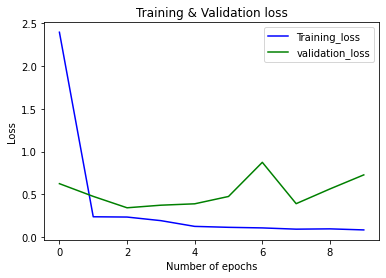

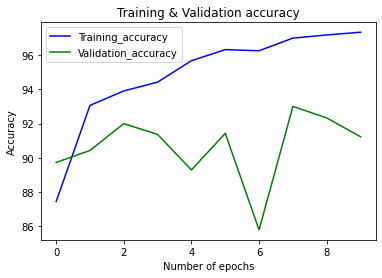

In [11]:
plt.plot(range(10), training_loss, 'b-', label='Training_loss')
plt.plot(range(10), validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(10), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(10), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loader = DataLoader(dataset=test_data, batch_size=8)
# model.eval()
correct_test_t = 0
total_test_t = 0
for test_batch_x, test_batch_y in test_loader:
        
    data,target = test_batch_x.to(device), test_batch_y.to(device)
        
    output = model(data)
       
    predicted = torch.max(output.data, 1)[1]
        
    total_test_t += len(target)
        
    correct_test_t += (predicted == target).float().sum()
        
test_accuracy = 100 * correct_test_t / float(total_test_t)

print('test_accuracy: {:.6f}%'.format(test_accuracy))

test_Loss: 0.0005924701690673828 test_accuracy: 92.107063%


In [ ]:
img_path = "/content/00000002_000.png"

# loader = transforms.Compose([transforms.Scale(224), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = transform11(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader(img_path)
model.eval()
output = model(image)
predicted = torch.max(output.data, 1)[1]
print (predicted)

tensor([1], device='cuda:0')


In [ ]:
torch.save(model, 'model.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
